<a href="https://colab.research.google.com/github/Pistolll/prak2_TOVII/blob/main/2prakTOVII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Импортируем библиотеки для обработки данных, машинного обучения и нейросетей
import gym
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Загружаем датасет CIC-DDoS2019 с GitHub
url = "https://raw.githubusercontent.com/Pistolll/prak2_TOVII/refs/heads/main/cicddos2019_dataset.csv"
df = pd.read_csv(url)

# Выводим первые строки таблицы
print("Пример данных:")
print(df.head())

# Смотрим уникальные значения метки трафика
print("\nТипы трафика:", df['Label'].unique())


Пример данных:
   Unnamed: 0  Protocol  Flow Duration  Total Fwd Packets  \
0           0        17         216631                  6   
1           1        17              2                  2   
2           2        17             48                  2   
3           3        17         107319                  4   
4           4        17         107271                  4   

   Total Backward Packets  Fwd Packets Length Total  Bwd Packets Length Total  \
0                       0                    2088.0                       0.0   
1                       0                     802.0                       0.0   
2                       0                     766.0                       0.0   
3                       0                    1398.0                       0.0   
4                       0                    1438.0                       0.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  ...  \
0                  393.0                  321.0    

In [3]:
# Заменяем строковые метки: 'Benign' → 0, всё остальное (атаки) → 1
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

# Удаляем пропущенные значения
df = df.dropna()

# Оставляем только числовые столбцы
df = df.select_dtypes(include=[np.number])

# Масштабируем признаки с помощью стандартизации (z-score)
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Label', axis=1))  # признаки
y = df['Label'].values  # метки

In [4]:
# Разбиваем данные: 80% - обучение, 20% - тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Создаём среду обучения на основе интерфейса OpenAI Gym
class TrafficEnv(gym.Env):
    def __init__(self, X, y):
        super(TrafficEnv, self).__init__()
        self.X = X  # входные данные
        self.y = y  # метки
        self.index = 0  # текущий индекс
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)  # действия: 0 = benign, 1 = attack

    def reset(self):
        self.index = 0  # сброс индекса
        return self.X[self.index]

    def step(self, action):
        label = self.y[self.index]  # истинная метка
        reward = 1 if action == label else -1  # +1 за правильную классификацию, -1 за ошибку
        self.index += 1
        done = self.index >= len(self.X)  # проверка конца эпизода
        obs = self.X[self.index] if not done else np.zeros_like(self.X[0])  # следующее наблюдение
        return obs, reward, done, {}


In [6]:
# Простая fully-connected нейросеть для Q-Learning
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # первый слой
            nn.ReLU(),  # активация
            nn.Linear(128, output_dim)  # выходной слой
        )

    def forward(self, x):
        return self.net(x)


In [7]:
# Функция обучения агента на среде
def train_agent(env, episodes=10, gamma=0.99, lr=1e-3):
    model = DQN(env.observation_space.shape[0], env.action_space.n)  # создаём модель
    optimizer = optim.Adam(model.parameters(), lr=lr)  # оптимизатор
    loss_fn = nn.MSELoss()  # функция потерь

    rewards_all = []  # список наград за эпизоды

    for episode in tqdm(range(episodes)):
        obs = torch.FloatTensor(env.reset())  # начальное состояние
        total_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                q_vals = model(obs)  # вычисляем Q-значения
            action = q_vals.argmax().item()  # выбираем действие с максимальным Q

            # Epsilon-greedy: иногда выбираем случайное действие
            if np.random.rand() < 0.1:
                action = env.action_space.sample()

            next_obs, reward, done, _ = env.step(action)  # делаем шаг
            next_obs_tensor = torch.FloatTensor(next_obs)

            q_target = reward + gamma * model(next_obs_tensor).max().item()  # вычисляем целевое значение

            loss = loss_fn(model(obs)[action], torch.tensor(q_target))  # считаем ошибку

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            obs = next_obs_tensor
            total_reward += reward

        rewards_all.append(total_reward)  # сохраняем награду за эпизод

    return model, rewards_all


100%|██████████| 30/30 [30:15<00:00, 60.51s/it]


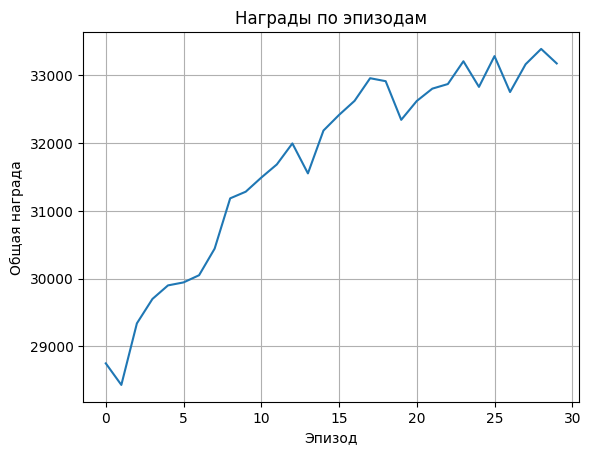

In [8]:
# Инициализация среды и запуск обучения агента
env = TrafficEnv(X_train, y_train)
model, rewards = train_agent(env, episodes=30)

# Визуализация наград по эпизодам
plt.plot(rewards)
plt.title("Награды по эпизодам")
plt.xlabel("Эпизод")
plt.ylabel("Общая награда")
plt.grid(True)
plt.show()


Ось X (горизонтальная) — номер эпизода обучения (от 0 до 29, всего 30 эпизодов).
Ось Y (вертикальная) — суммарная награда, полученная агентом за один эпизод.
Кривая — показывает, как менялась общая награда по мере обучения агента.


Что такое награда в Reinforcement Learning
В обучении с подкреплением:

Агент принимает решения (в нашем случае — классифицирует сетевой трафик как Benign или Attack);

За каждое действие он получает награду:
+1, если правильно классифицировал (например, верно определил атаку);
−1, если ошибся (например, пропустил вредоносный запрос).

Суммарная награда за эпизод — это общее количество очков, набранных агентом при прохождении всей выборки.

In [9]:
# Оцениваем точность классификации RL-модели
def evaluate_model(model, X, y):
    X = torch.FloatTensor(X)  # преобразуем в тензоры
    preds = model(X).argmax(dim=1).numpy()  # получаем предсказания
    from sklearn.metrics import classification_report
    print(classification_report(y, preds, target_names=["Benign", "Attack"]))  # метрики

evaluate_model(model, X_test, y_test)


              precision    recall  f1-score   support

      Benign       0.97      0.98      0.97      1433
      Attack       1.00      0.99      1.00      8281

    accuracy                           0.99      9714
   macro avg       0.98      0.99      0.98      9714
weighted avg       0.99      0.99      0.99      9714



Объяснение метрик:
Precision	Точность — сколько предсказанных Attack действительно были атаками
Recall	Полнота — сколько всех реальных Attack было правильно найдено
F1-score	Среднее между precision и recall
Support	Сколько всего примеров каждого класса в тесте

In [11]:
# Обучаем классическую модель Random Forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

# Выводим метрики качества
print("\n Сравнение с RandomForest:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf, target_names=["Benign", "Attack"]))



 Сравнение с RandomForest:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1433
      Attack       1.00      1.00      1.00      8281

    accuracy                           1.00      9714
   macro avg       1.00      1.00      1.00      9714
weighted avg       1.00      1.00      1.00      9714

